# Schedule optimizer

Based on https://developers.google.com/optimization/scheduling/job_shop

In [19]:
#### Run this cell to install ortools before running the rest of the notebook if you are using Google Colab
!pip install ortools

In [20]:
import collections
from ortools.sat.python import cp_model
import pandas as pd
from matplotlib import pyplot as plt

First let's take a quick look at how the input data is structured in the OR-tools example job shop scheduler:

In [21]:
jobs_data = [  # task = (machine_id, processing_time).
    [(0, 3), (1, 2), (2, 2)],  # Job0
    [(0, 2), (2, 1), (1, 4)],  # Job1
    [(1, 4), (2, 3)],  # Job2
]

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

In [22]:
jobs_data

[[(0, 3), (1, 2), (2, 2)], [(0, 2), (2, 1), (1, 4)], [(1, 4), (2, 3)]]

Let's take as input our 3 dataframes from the simpy notebook, and write them in format of the sample `jobs_data` above

In [23]:
df_materials = pd.DataFrame(
    [
        {
            'name': 'supercrane',
            'type': 'finished_good',
            'inputs': ['copy_paper','staple'],
            'recipe': ['S_tl','C_n','G1'],
            'sales_price': 24,
        },
        {
            'name': 'birthday_card',
            'type': 'finished_good',
            'inputs': ['folded_card','staple'],
            'recipe': ['F_h','S_tl','G1'],
            'sales_price': 8.5,
        },
        {
            'name': 'holey_folder',
            'type': 'finished_good',
            'inputs': ['folded_card','staple'],
            'recipe': ['S_tl','P_h','P_h','P_h','S_bl'],
            'sales_price': 9.10,
        },
        {
            'name': 'folded_card',
            'type': 'intermediate_product',
            'inputs': ['construction_paper'],
            'recipe': ['F_h'],
        },
        {
            'name': 'triangle',
            'type': 'finished_good',
            'inputs': ['copy_paper'],
            'recipe': ['F_d','G1'],
            'sales_price': 16.2,
        },
        {
            'name': '2_ply_circle',
            'type': 'finished_good',
            'inputs': ['copy_paper'],
            'recipe': ['C_c','G1'],
            'sales_price': 37,
        },
        {
            'name': 'copy_paper',
            'type': 'raw_material',
            'inputs': [],
            'recipe': [],
            'initial_qty': 100
        },
        {
            'name': 'construction_paper',
            'type': 'raw_material',
            'inputs': [],
            'recipe': [],
            'initial_qty': 25
        },
        {
            'name': 'staple',
            'type': 'raw_material',
            'inputs': [],
            'recipe': [],
            'initial_qty': 200
        },
    ]
)


df_operations = pd.DataFrame(
    [
        {
            'name': 'Staple Top Left Corner',
            'id' : 'S_tl',
            'resources': ['stapler'],
        },
        {
            'name': 'Staple Bottom Left Corner',
            'id' : 'S_bl',
            'resources': ['stapler'],
        },
        {
            'name': 'Glue',
            'id':'G1',
            'resources': ['glue'],
        },
        {
            'name': 'Fold Diagonal',
            'id':'F_d',
            'resources': ['folding_station'],
        },
        {
            'name': 'Cut Notch',
            'id':'C_n',
            'resources': ['scissors'],
        },
        {
            'name': 'Cut Circle',
            'id':'C_c',
            'resources': ['scissors'],
        },
        {
            'name': 'Punch Hole',
            'id':'P_h',
            'resources': ['hole_punch'],
        },
        {
            'name': 'Fold in Half',
            'id':'F_h',
            'resources': ['folding_station'],
        },
    ]
)

df_resources = pd.DataFrame(
    [
        {
            'name': 'stapler',
            'num_units' : 1,
            'num_operators': 2,
            'capacity_per_unit': 1,
            'setup_time': 25,
            'cycle_time_mean': 25,
            'cycle_time_std': 4,
        },
        {
            'name': 'glue',
            'num_units' : 4,
            'setup_time': 18,
            'num_operators': 1,
            'cycle_time_mean': 120,
            'cycle_time_std': 30,
        },
        {
            'name': 'scissors',
            'num_units' : 3,
            'setup_time': 18,
            'num_operators': 1,
            'cycle_time_mean': 48,
            'cycle_time_std': 24,
        },
        {
            'name': 'folding_station',
            'num_units' : 99, # we don't actually have 99 units, but since no physical equipment is required for folding, it is only constrained by available operators
            'setup_time': 18,
            'num_operators': 1,
            'cycle_time_mean': 16,
            'cycle_time_std': 8,
        },
        {
            'name': 'hole_punch',
            'num_units' : 1,
            'setup_time': 10,
            'num_operators': 1,
            'cycle_time_mean': 12,
            'cycle_time_std': 4,
        },
    ]
)

In [24]:
### add a machine index starting from 0 to each resource:
df_resources['machine_index'] = df_resources.index.values


# we are going to define a number of jobs to schedule in a batch, sample that from the finished goods, then populate the jobs list for each one:
# since some of the finished goods have intermediate goods as input, create a new job to process that intermediate good
NUM_JOBS = 20

NUM_OPERATORS = 5

def create_job(job_row):
    # input is a row of a dataframe
    # for each step in the job's recipe, look up the associated resource, and append its index and total duration (setup + mean cycle time) as a tuple
    job_steps = []
    for step in job_row.recipe.item():
        resource_name = df_operations.loc[df_operations.id == step,:].resources.item()[0]
        resource_row = df_resources.loc[df_resources.name == resource_name,:].sample(1)
        job_steps.append((resource_row.machine_index.item(), resource_row.setup_time.item() + resource_row.cycle_time_mean.item()))

    return job_steps

job_list = []
precedence_constraints = []
job_names = []
for j in range(NUM_JOBS):
    job_row = df_materials.loc[df_materials.type == 'finished_good',:].sample(1)
    job_list.append(create_job(job_row))
    job_names.append(job_row.name.item())
    parent_job_index = len(job_list) - 1
    for input in job_row.inputs.item():
        input_row = df_materials.loc[df_materials.name == input,:]
        if input_row.type.item() == 'intermediate_product':
            job_list.append(create_job(input_row))
            job_names.append(input_row.name.item())
            # record the need for a precedence constraint - the intermediate job must be completed before the parent job can start
            intermediate_job_index = len(job_list) - 1
            precedence_constraints.append((intermediate_job_index, parent_job_index))

print(job_list)
print(precedence_constraints)

jobs_data = job_list

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

[[(0, 50), (2, 66), (1, 138)], [(2, 66), (1, 138)], [(3, 34), (0, 50), (1, 138)], [(3, 34)], [(0, 50), (4, 22), (4, 22), (4, 22), (0, 50)], [(3, 34)], [(3, 34), (1, 138)], [(0, 50), (4, 22), (4, 22), (4, 22), (0, 50)], [(3, 34)], [(3, 34), (1, 138)], [(0, 50), (2, 66), (1, 138)], [(2, 66), (1, 138)], [(2, 66), (1, 138)], [(0, 50), (2, 66), (1, 138)], [(0, 50), (4, 22), (4, 22), (4, 22), (0, 50)], [(3, 34)], [(0, 50), (4, 22), (4, 22), (4, 22), (0, 50)], [(3, 34)], [(3, 34), (0, 50), (1, 138)], [(3, 34)], [(2, 66), (1, 138)], [(0, 50), (2, 66), (1, 138)], [(3, 34), (1, 138)], [(0, 50), (2, 66), (1, 138)], [(3, 34), (0, 50), (1, 138)], [(3, 34)], [(3, 34), (0, 50), (1, 138)], [(3, 34)]]
[(3, 2), (5, 4), (8, 7), (15, 14), (17, 16), (19, 18), (25, 24), (27, 26)]


In [25]:
len(job_list)

28

In [26]:
model = cp_model.CpModel()

In [27]:
# Named tuple to store information about created variables.
task_type = collections.namedtuple("task_type", "start end interval")
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

# Creates job intervals and add to the corresponding machine lists.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f"_{job_id}_{task_id}"
        start_var = model.NewIntVar(0, horizon, "start" + suffix)
        end_var = model.NewIntVar(0, horizon, "end" + suffix)
        interval_var = model.NewIntervalVar(
            start_var, duration, end_var, "interval" + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)

In [28]:
# Create and add disjunctive constraints.
# for machine in all_machines:
#     model.AddNoOverlap(machine_to_intervals[machine])

# Change to a cumulative constraint based on each machine's capacity
# for develpoment, start with all machines having capacity = 1
for machine in all_machines:
    capacity = df_resources.loc[df_resources['machine_index'] == machine,'num_units'].item()
    model.AddCumulative(machine_to_intervals[machine],[1 for i in range(len(machine_to_intervals[machine]))],capacity=capacity)

# Use a capacity constraint to limit the number of concurrent jobs to the number of operators
# the number of operators required for a given interval is based on the num_operators parameter of each machine
all_intervals = []
all_operator_requirements = []
for machine in all_machines:
    all_intervals.extend(machine_to_intervals[machine])
    all_operator_requirements.extend([df_resources.loc[df_resources['machine_index'] == machine,'num_operators'].item() for i in range(len(machine_to_intervals[machine]))])
model.AddCumulative(all_intervals,all_operator_requirements,capacity=NUM_OPERATORS)

# Precedences inside a job.
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        model.Add(
            all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
        )

In [29]:
# Precedences between jobs
for pc in precedence_constraints:
    input_id = pc[0]
    input_last_task = len(jobs_data[input_id]) - 1
    output_id = pc[1]
    output_first_task = 0
    model.Add(
        all_tasks[output_id,output_first_task].start >= all_tasks[input_id,input_last_task].end
    )

In [30]:
# Makespan objective.
obj_var = model.NewIntVar(0, horizon, "makespan")
model.AddMaxEquality(
    obj_var,
    [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
)
model.Minimize(obj_var)

In [31]:
solver = cp_model.CpSolver()

# This parameter ensures the solver returns its best results available after a specified time
# You can play with varying this parameter and observe sensitivity of the objetive function value
solver.parameters.max_time_in_seconds = 15.0

# This function defines a callback that gets executed during the solver run:
class SolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__solution_count = 0

    def on_solution_callback(self):
        """Called at each new solution."""
        print('Solution %i, time = %f s, objective = %i' %
              (self.__solution_count, self.WallTime(), self.ObjectiveValue()),flush=True)
        self.__solution_count += 1

solution_printer = SolutionPrinter()


status = solver.Solve(model,solution_printer)

Solution 0, time = 0.010958 s, objective = 1248
Solution 1, time = 0.016892 s, objective = 1198
Solution 2, time = 0.023763 s, objective = 1165
Solution 3, time = 0.029088 s, objective = 1164
Solution 4, time = 0.033228 s, objective = 1160
Solution 5, time = 0.042731 s, objective = 1156
Solution 6, time = 0.049484 s, objective = 1148
Solution 7, time = 0.059615 s, objective = 1140
Solution 8, time = 0.066788 s, objective = 1126
Solution 9, time = 0.078327 s, objective = 1114
Solution 10, time = 0.085665 s, objective = 1110
Solution 11, time = 0.095066 s, objective = 1106
Solution 12, time = 0.106185 s, objective = 1098
Solution 13, time = 0.113592 s, objective = 1094
Solution 14, time = 0.195305 s, objective = 1092
Solution 15, time = 0.246868 s, objective = 1090
Solution 16, time = 0.254605 s, objective = 1088
Solution 17, time = 0.263153 s, objective = 1084
Solution 18, time = 0.300938 s, objective = 1082
Solution 19, time = 0.339432 s, objective = 1080
Solution 20, time = 0.355073 s

In [32]:
import pandas as pd
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution:")
    # Create one list of assigned tasks per machine.
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.Value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1],
                )
            )

    # Create per machine output lines.
    output = ""
    schedule_dicts = []
    for machine in all_machines:
        # Sort by starting time.
        assigned_jobs[machine].sort()
        sol_line_tasks = "Machine " + str(machine) + ": "
        sol_line = "           "

        for assigned_task in assigned_jobs[machine]:
            name = f"job_{assigned_task.job}_task_{assigned_task.index}"
            # Add spaces to output to align columns.
            sol_line_tasks += f"{name:15}"

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = f"[{start},{start + duration}]"
            # Add spaces to output to align columns.
            sol_line += f"{sol_tmp:15}"

            schedule_dicts.append({'machine_id':machine,"machine": df_resources.loc[machine,'name'], "start": start, "duration": duration, 'job_id':assigned_task.job, 'job':job_names[assigned_task.job]})

        sol_line += "\n"
        sol_line_tasks += "\n"
        output += sol_line_tasks
        output += sol_line

    # Finally print the solution found.
    print(f"Optimal Schedule Length: {solver.ObjectiveValue()}")
    print(output)
else:
    print("No solution found.")


# Statistics.
print("\nStatistics")
print(f"  - conflicts: {solver.NumConflicts()}")
print(f"  - branches : {solver.NumBranches()}")
print(f"  - wall time: {solver.WallTime()}s")

df = pd.DataFrame(schedule_dicts)

Solution:
Optimal Schedule Length: 1058.0
Machine 0: job_24_task_1  job_16_task_0  job_4_task_0   job_7_task_0   job_10_task_0  job_2_task_1   job_0_task_0   job_23_task_0  job_18_task_1  job_14_task_0  job_21_task_0  job_13_task_0  job_7_task_4   job_26_task_1  job_14_task_4  job_4_task_4   job_16_task_4  
           [68,118]       [204,254]      [256,306]      [340,390]      [390,440]      [458,508]      [508,558]      [558,608]      [608,658]      [658,708]      [708,758]      [758,808]      [808,858]      [858,908]      [908,958]      [958,1008]     [1008,1058]    
Machine 1: job_1_task_1   job_12_task_1  job_22_task_1  job_24_task_2  job_6_task_1   job_9_task_1   job_20_task_1  job_11_task_1  job_10_task_2  job_2_task_2   job_0_task_2   job_23_task_2  job_18_task_2  job_21_task_2  job_13_task_2  job_26_task_2  
           [66,204]       [66,204]       [118,256]      [204,342]      [252,390]      [320,458]      [342,480]      [440,578]      [506,644]      [578,716]      [644,782]  

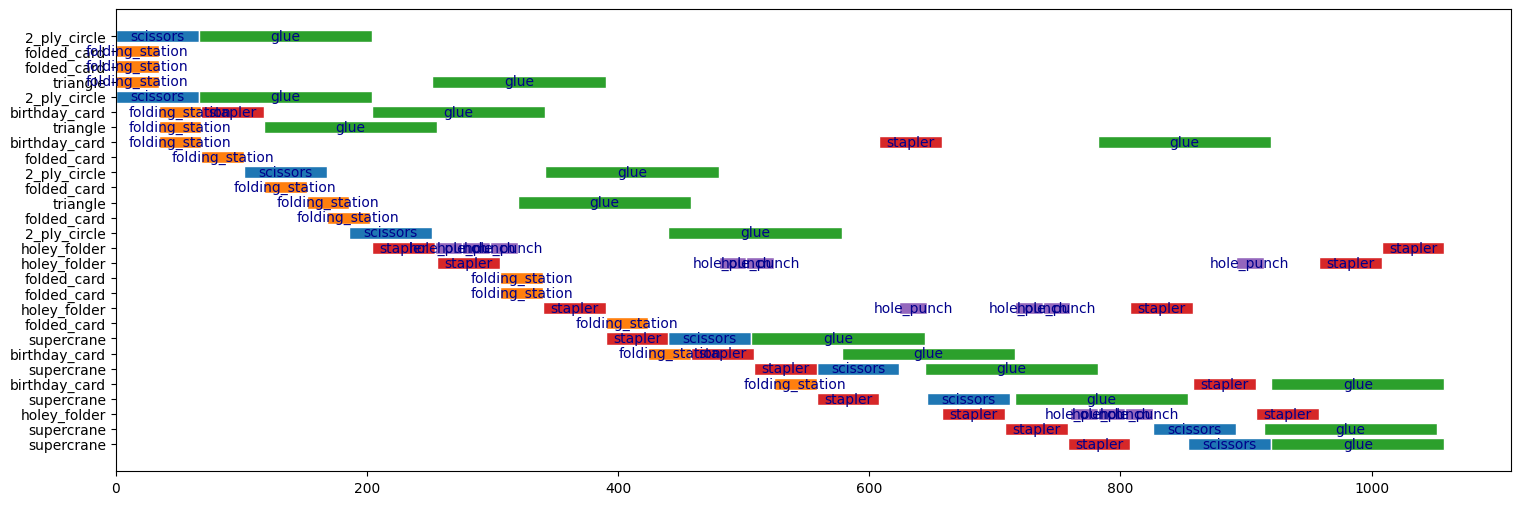

In [33]:
# plot in ordder and color by machine
fig, ax = plt.subplots(figsize=(18,6))
df = df.sort_values('start')
df['job_rank'] = df.groupby('job_id',sort=False)['start'].ngroup(ascending=False)
#jitter_count = 5
for i , machine_id in enumerate(df.machine.unique()):
    bars = ax.barh(y=df.loc[df.machine==machine_id,'job_rank'], width=df.loc[df.machine==machine_id,'duration'], left=df.loc[df.machine==machine_id,'start'],linewidth=1,edgecolor='white') # linewidth + edgecolor lets us see gaps in contiguous steps same machine
    ax.bar_label(bars,df.loc[df.machine==machine_id,'machine'],label_type='center',rotation=0,color='darkblue')
    ax.set_yticks([x for x in range(df.job_id.max()+1)])
    ax.set_yticklabels(df.groupby('job_rank')['job'].first().tolist())
plt.show()